In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, hstack
from astropy.io import fits
import pandas as pd
from edge_pydb.fitsextract import fitsextract, getlabels
from pyFIT3D.modelling.stellar import SSPModels

# SFH lum-to-mass conversion for new (CALIFA eDR) files

### The SSP table is the 2nd extension of `eCALIFA.pyPipe3D.fits` from https://ifs.astroscu.unam.mx/CALIFA/V500/v2.3/tables/

In [2]:
ssptable='/Users/tonywong/Scratch2/califa/eDR/MASTAR_CB19_SSP.fits'
models = SSPModels(ssptable)
nlumcols = models.n_models
print('Number of model steps:',nlumcols)
models.mass_to_light

Number of model steps: 273


array([  275.5504,   228.9639,   203.5582,   152.4274,   130.7224,   114.1279,   100.954 ,   212.5805,   178.4153,   156.6195,   104.0594,    78.2534,    65.8501,    59.6338,    66.2164,    34.5244,
          20.5351,    45.6475,    60.6943,    69.1946,    72.7643,   201.6292,   144.6362,    73.0941,    47.201 ,    72.0773,   108.2064,   116.2466,   302.6543,   223.2392,   153.3178,   104.5981,
         191.2777,   200.2243,   198.8427,   408.3966,   313.7649,   167.1039,   173.8616,   194.171 ,   278.8   ,   284.9084,   481.6028,   351.5927,   287.4554,   257.9979,   336.2814,   337.4958,
         344.4475,   523.5876,   360.0101,   298.7572,   407.017 ,   342.372 ,   411.8955,   412.7626,   578.2018,   401.1392,   338.9716,   434.537 ,   380.4162,   441.2284,   485.0601,   635.7683,
         452.1   ,   386.4436,   420.4684,   426.4029,   514.6151,   554.3237,   704.9203,   517.3573,   450.4302,   493.3399,   478.0343,   596.5875,   637.1456,   778.089 ,   586.6135,   521.7028,
     

## Read and process the FITS file

In [3]:
gname = 'NGC5485'
fitsdir = '../../edge_pydb/img_califa/fits_ecalifa/'
cafile = os.path.join(fitsdir,gname+'.Pipe3D.cube.fits.gz')
hdul = fits.open(cafile, ignore_missing_end=True)
cahd = hdul['SFH'].header
cadat = hdul['SFH'].data
zsel, labels, units, nsel, has_errors, fluxlike = getlabels('SFH', p3dstruct='ecalifa')

In [4]:
p3dhd = hdul[0].header
p3dhd['CTYPE3'] = ''
# Set CDELT3 to 1 since that will be its value in template
for key in ['CDELT3', 'CD3_3']:
    if key in p3dhd.keys():
        p3dhd[key] = 1.
w_cahd = p3dhd.copy()
# Fixes issue where header 0 has no NAXIS1 or NAXIS2
for key in ['NAXIS2', 'NAXIS1']:
    if key in w_cahd.keys():
        del w_cahd[key]
    w_cahd.insert('NAXIS', (key, cahd[key]), after=True)
# Apply blanking masks
msk = hdul['GAIA_MASK'].data
msk3d = np.broadcast_to(msk, cadat.shape)
cadat[msk3d>0] = np.nan
sel = hdul['SELECT_REG'].data
sel3d = np.broadcast_to(sel, cadat.shape)
cadat[sel3d<1] = np.nan

In [5]:
sfh = fitsextract(cadat, header=w_cahd, keepnan=True, stride=[3,3,1], 
                  bunit=units, col_lbl=labels, zselect=zsel, 
                  first=False, use_hexgrid=False)

RA ref is 211.7971932610542
DEC ref is 55.00103996501454
This is an image of shape (319, 150, 160)
Axis 1: crpix=79.0
Axis 2: crpix=63.0
Remainder:  [0, 2, 0]


## The original SFH table has a column for each age-metallicity pair

In [6]:
print(len(sfh.colnames), sfh.colnames)

321 ['ix', 'iy', 'lumfrac_age_0.0010_met_0.0001', 'lumfrac_age_0.0010_met_0.0005', 'lumfrac_age_0.0010_met_0.0020', 'lumfrac_age_0.0010_met_0.0080', 'lumfrac_age_0.0010_met_0.0170', 'lumfrac_age_0.0010_met_0.0300', 'lumfrac_age_0.0010_met_0.0400', 'lumfrac_age_0.0023_met_0.0001', 'lumfrac_age_0.0023_met_0.0005', 'lumfrac_age_0.0023_met_0.0020', 'lumfrac_age_0.0023_met_0.0080', 'lumfrac_age_0.0023_met_0.0170', 'lumfrac_age_0.0023_met_0.0300', 'lumfrac_age_0.0023_met_0.0400', 'lumfrac_age_0.0038_met_0.0001', 'lumfrac_age_0.0038_met_0.0005', 'lumfrac_age_0.0038_met_0.0020', 'lumfrac_age_0.0038_met_0.0080', 'lumfrac_age_0.0038_met_0.0170', 'lumfrac_age_0.0038_met_0.0300', 'lumfrac_age_0.0038_met_0.0400', 'lumfrac_age_0.0057_met_0.0001', 'lumfrac_age_0.0057_met_0.0005', 'lumfrac_age_0.0057_met_0.0020', 'lumfrac_age_0.0057_met_0.0080', 'lumfrac_age_0.0057_met_0.0170', 'lumfrac_age_0.0057_met_0.0300', 'lumfrac_age_0.0057_met_0.0400', 'lumfrac_age_0.0080_met_0.0001', 'lumfrac_age_0.0080_met_0.

### In addition to ix and iy there are 319 columns in the table.  With 39 ages and 7 metallicities there are 39x7 = 273 luminosity fraction columns.  An additional 39+7 = 46 columns aggregate over age and metallicity respectively.

## Derive mass fraction columns from the luminosity fraction columns.

In [7]:
idx0 = 2
lumcols = Table(sfh.columns[idx0:idx0+nlumcols])
lumcols

lumfrac_age_0.0010_met_0.0001,lumfrac_age_0.0010_met_0.0005,lumfrac_age_0.0010_met_0.0020,lumfrac_age_0.0010_met_0.0080,lumfrac_age_0.0010_met_0.0170,lumfrac_age_0.0010_met_0.0300,lumfrac_age_0.0010_met_0.0400,lumfrac_age_0.0023_met_0.0001,lumfrac_age_0.0023_met_0.0005,lumfrac_age_0.0023_met_0.0020,lumfrac_age_0.0023_met_0.0080,lumfrac_age_0.0023_met_0.0170,lumfrac_age_0.0023_met_0.0300,lumfrac_age_0.0023_met_0.0400,lumfrac_age_0.0038_met_0.0001,lumfrac_age_0.0038_met_0.0005,lumfrac_age_0.0038_met_0.0020,lumfrac_age_0.0038_met_0.0080,lumfrac_age_0.0038_met_0.0170,lumfrac_age_0.0038_met_0.0300,lumfrac_age_0.0038_met_0.0400,lumfrac_age_0.0057_met_0.0001,lumfrac_age_0.0057_met_0.0005,lumfrac_age_0.0057_met_0.0020,lumfrac_age_0.0057_met_0.0080,lumfrac_age_0.0057_met_0.0170,lumfrac_age_0.0057_met_0.0300,lumfrac_age_0.0057_met_0.0400,lumfrac_age_0.0080_met_0.0001,lumfrac_age_0.0080_met_0.0005,lumfrac_age_0.0080_met_0.0020,lumfrac_age_0.0080_met_0.0080,lumfrac_age_0.0080_met_0.0170,lumfrac_age_0.0080_met_0.0300,lumfrac_age_0.0080_met_0.0400,lumfrac_age_0.0115_met_0.0001,lumfrac_age_0.0115_met_0.0005,lumfrac_age_0.0115_met_0.0020,lumfrac_age_0.0115_met_0.0080,lumfrac_age_0.0115_met_0.0170,lumfrac_age_0.0115_met_0.0300,lumfrac_age_0.0115_met_0.0400,lumfrac_age_0.0150_met_0.0001,lumfrac_age_0.0150_met_0.0005,lumfrac_age_0.0150_met_0.0020,lumfrac_age_0.0150_met_0.0080,lumfrac_age_0.0150_met_0.0170,lumfrac_age_0.0150_met_0.0300,lumfrac_age_0.0150_met_0.0400,lumfrac_age_0.0200_met_0.0001,lumfrac_age_0.0200_met_0.0005,lumfrac_age_0.0200_met_0.0020,lumfrac_age_0.0200_met_0.0080,lumfrac_age_0.0200_met_0.0170,lumfrac_age_0.0200_met_0.0300,lumfrac_age_0.0200_met_0.0400,lumfrac_age_0.0260_met_0.0001,lumfrac_age_0.0260_met_0.0005,lumfrac_age_0.0260_met_0.0020,lumfrac_age_0.0260_met_0.0080,lumfrac_age_0.0260_met_0.0170,lumfrac_age_0.0260_met_0.0300,lumfrac_age_0.0260_met_0.0400,lumfrac_age_0.0330_met_0.0001,lumfrac_age_0.0330_met_0.0005,lumfrac_age_0.0330_met_0.0020,lumfrac_age_0.0330_met_0.0080,lumfrac_age_0.0330_met_0.0170,lumfrac_age_0.0330_met_0.0300,lumfrac_age_0.0330_met_0.0400,lumfrac_age_0.0425_met_0.0001,lumfrac_age_0.0425_met_0.0005,lumfrac_age_0.0425_met_0.0020,lumfrac_age_0.0425_met_0.0080,lumfrac_age_0.0425_met_0.0170,lumfrac_age_0.0425_met_0.0300,lumfrac_age_0.0425_met_0.0400,lumfrac_age_0.0535_met_0.0001,lumfrac_age_0.0535_met_0.0005,lumfrac_age_0.0535_met_0.0020,lumfrac_age_0.0535_met_0.0080,lumfrac_age_0.0535_met_0.0170,lumfrac_age_0.0535_met_0.0300,lumfrac_age_0.0535_met_0.0400,lumfrac_age_0.0700_met_0.0001,lumfrac_age_0.0700_met_0.0005,lumfrac_age_0.0700_met_0.0020,lumfrac_age_0.0700_met_0.0080,lumfrac_age_0.0700_met_0.0170,lumfrac_age_0.0700_met_0.0300,lumfrac_age_0.0700_met_0.0400,lumfrac_age_0.0900_met_0.0001,lumfrac_age_0.0900_met_0.0005,lumfrac_age_0.0900_met_0.0020,lumfrac_age_0.0900_met_0.0080,lumfrac_age_0.0900_met_0.0170,lumfrac_age_0.0900_met_0.0300,lumfrac_age_0.0900_met_0.0400,lumfrac_age_0.1100_met_0.0001,lumfrac_age_0.1100_met_0.0005,lumfrac_age_0.1100_met_0.0020,lumfrac_age_0.1100_met_0.0080,lumfrac_age_0.1100_met_0.0170,lumfrac_age_0.1100_met_0.0300,lumfrac_age_0.1100_met_0.0400,lumfrac_age_0.1400_met_0.0001,lumfrac_age_0.1400_met_0.0005,lumfrac_age_0.1400_met_0.0020,lumfrac_age_0.1400_met_0.0080,lumfrac_age_0.1400_met_0.0170,lumfrac_age_0.1400_met_0.0300,lumfrac_age_0.1400_met_0.0400,lumfrac_age_0.1800_met_0.0001,lumfrac_age_0.1800_met_0.0005,lumfrac_age_0.1800_met_0.0020,lumfrac_age_0.1800_met_0.0080,lumfrac_age_0.1800_met_0.0170,lumfrac_age_0.1800_met_0.0300,lumfrac_age_0.1800_met_0.0400,lumfrac_age_0.2250_met_0.0001,lumfrac_age_0.2250_met_0.0005,lumfrac_age_0.2250_met_0.0020,lumfrac_age_0.2250_met_0.0080,lumfrac_age_0.2250_met_0.0170,lumfrac_age_0.2250_met_0.0300,lumfrac_age_0.2250_met_0.0400,lumfrac_age_0.2750_met_0.0001,lumfrac_age_0.2750_met_0.0005,lumfrac_age_0.2750_met_0.0020,lumfrac_age_0.2750_met_0.0080,lumfrac_age_0.2750_met_0.0170,lumfrac_age_0.2750_met_0.0300,lumfrac_age_0.2750_met_0.0400,lumfrac_ag

In [8]:
df_lum = lumcols.to_pandas()
df_lum

,lumfrac_age_0.0010_met_0.0001,lumfrac_age_0.0010_met_0.0005,lumfrac_age_0.0010_met_0.0020,lumfrac_age_0.0010_met_0.0080,lumfrac_age_0.0010_met_0.0170,lumfrac_age_0.0010_met_0.0300,lumfrac_age_0.0010_met_0.0400,lumfrac_age_0.0023_met_0.0001,lumfrac_age_0.0023_met_0.0005,lumfrac_age_0.0023_met_0.0020,...,lumfrac_age_12.0000_met_0.0170,lumfrac_age_12.0000_met_0.0300,lumfrac_age_12.0000_met_0.0400,lumfrac_age_13.5000_met_0.0001,lumfrac_age_13.5000_met_0.0005,lumfrac_age_13.5000_met_0.0020,lumfrac_age_13.5000_met_0.0080,lumfrac_age_13.5000_met_0.0170,lumfrac_age_13.5000_met_0.0300,lumfrac_age_13.5000_met_0.0400
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_mass = df_lum.multiply(models.mass_to_light, axis='columns')
df_norm = df_mass.divide(df_mass.sum(axis=1), axis='index')
df_norm.columns = [x.replace('lum','mass') for x in list(df_norm.columns)]
df_norm

,massfrac_age_0.0010_met_0.0001,massfrac_age_0.0010_met_0.0005,massfrac_age_0.0010_met_0.0020,massfrac_age_0.0010_met_0.0080,massfrac_age_0.0010_met_0.0170,massfrac_age_0.0010_met_0.0300,massfrac_age_0.0010_met_0.0400,massfrac_age_0.0023_met_0.0001,massfrac_age_0.0023_met_0.0005,massfrac_age_0.0023_met_0.0020,...,massfrac_age_12.0000_met_0.0170,massfrac_age_12.0000_met_0.0300,massfrac_age_12.0000_met_0.0400,massfrac_age_13.5000_met_0.0001,massfrac_age_13.5000_met_0.0005,massfrac_age_13.5000_met_0.0020,massfrac_age_13.5000_met_0.0080,massfrac_age_13.5000_met_0.0170,massfrac_age_13.5000_met_0.0300,massfrac_age_13.5000_met_0.0400
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Extract age and metallicity values from column labels

In [10]:
agecols = [s.split('_')[2] for s in df_norm.columns.values]
print('Ages:',agecols)
metcols = [s.split('_')[4] for s in df_norm.columns.values]
print('Metallicities:',metcols)

Ages: ['0.0010', '0.0010', '0.0010', '0.0010', '0.0010', '0.0010', '0.0010', '0.0023', '0.0023', '0.0023', '0.0023', '0.0023', '0.0023', '0.0023', '0.0038', '0.0038', '0.0038', '0.0038', '0.0038', '0.0038', '0.0038', '0.0057', '0.0057', '0.0057', '0.0057', '0.0057', '0.0057', '0.0057', '0.0080', '0.0080', '0.0080', '0.0080', '0.0080', '0.0080', '0.0080', '0.0115', '0.0115', '0.0115', '0.0115', '0.0115', '0.0115', '0.0115', '0.0150', '0.0150', '0.0150', '0.0150', '0.0150', '0.0150', '0.0150', '0.0200', '0.0200', '0.0200', '0.0200', '0.0200', '0.0200', '0.0200', '0.0260', '0.0260', '0.0260', '0.0260', '0.0260', '0.0260', '0.0260', '0.0330', '0.0330', '0.0330', '0.0330', '0.0330', '0.0330', '0.0330', '0.0425', '0.0425', '0.0425', '0.0425', '0.0425', '0.0425', '0.0425', '0.0535', '0.0535', '0.0535', '0.0535', '0.0535', '0.0535', '0.0535', '0.0700', '0.0700', '0.0700', '0.0700', '0.0700', '0.0700', '0.0700', '0.0900', '0.0900', '0.0900', '0.0900', '0.0900', '0.0900', '0.0900', '0.1100', '0.

## Aggregate the mass fractions by age.  Reorder them by increasing age.

In [11]:
df_age = (df_norm.T).groupby(agecols, sort=False).sum(min_count=1).T
df_age = df_age.reindex(sorted(df_age.columns, key=float), axis=1)
sort_ages = list(df_age.columns)
print(sort_ages)
df_age.columns = ['massfrac_age_'+x for x in sort_ages]
df_age

['0.0010', '0.0023', '0.0038', '0.0057', '0.0080', '0.0115', '0.0150', '0.0200', '0.0260', '0.0330', '0.0425', '0.0535', '0.0700', '0.0900', '0.1100', '0.1400', '0.1800', '0.2250', '0.2750', '0.3500', '0.4500', '0.5500', '0.6500', '0.8500', '1.1000', '1.3000', '1.6000', '2.0000', '2.5000', '3.0000', '3.7500', '4.5000', '5.2500', '6.2500', '7.5000', '8.5000', '10.2500', '12.0000', '13.5000']


,massfrac_age_0.0010,massfrac_age_0.0023,massfrac_age_0.0038,massfrac_age_0.0057,massfrac_age_0.0080,massfrac_age_0.0115,massfrac_age_0.0150,massfrac_age_0.0200,massfrac_age_0.0260,massfrac_age_0.0330,...,massfrac_age_3.0000,massfrac_age_3.7500,massfrac_age_4.5000,massfrac_age_5.2500,massfrac_age_6.2500,massfrac_age_7.5000,massfrac_age_8.5000,massfrac_age_10.2500,massfrac_age_12.0000,massfrac_age_13.5000
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Sample row
df_age.loc[1680]

massfrac_age_0.0010     0.000000
massfrac_age_0.0023     0.000000
massfrac_age_0.0038     0.000000
massfrac_age_0.0057     0.000000
massfrac_age_0.0080     0.000000
massfrac_age_0.0115     0.000000
massfrac_age_0.0150     0.000000
massfrac_age_0.0200     0.000000
massfrac_age_0.0260     0.000000
massfrac_age_0.0330     0.000000
massfrac_age_0.0425     0.000000
massfrac_age_0.0535     0.000000
massfrac_age_0.0700     0.000000
massfrac_age_0.0900     0.000000
massfrac_age_0.1100     0.000000
massfrac_age_0.1400     0.000000
massfrac_age_0.1800     0.000000
massfrac_age_0.2250     0.000000
massfrac_age_0.2750     0.000000
massfrac_age_0.3500     0.000000
massfrac_age_0.4500     0.000000
massfrac_age_0.5500     0.000000
massfrac_age_0.6500     0.000188
massfrac_age_0.8500     0.001524
massfrac_age_1.1000     0.011930
massfrac_age_1.3000     0.005021
massfrac_age_1.6000     0.063411
massfrac_age_2.0000     0.005979
massfrac_age_2.5000     0.000000
massfrac_age_3.0000     0.065870
massfrac_a

## Aggregate the mass fractions by metallicity.

In [13]:
df_met = (df_norm.T).groupby(metcols).sum(min_count=1).T
sort_mets = list(df_met.columns)
print(sort_mets)
df_met.columns = ['massfrac_met_'+x for x in sort_mets]
df_met

['0.0001', '0.0005', '0.0020', '0.0080', '0.0170', '0.0300', '0.0400']


,massfrac_met_0.0001,massfrac_met_0.0005,massfrac_met_0.0020,massfrac_met_0.0080,massfrac_met_0.0170,massfrac_met_0.0300,massfrac_met_0.0400
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2695,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2697,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2698,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Sample row
df_met.loc[1680]

massfrac_met_0.0001    0.000000
massfrac_met_0.0005    0.000000
massfrac_met_0.0020    0.003953
massfrac_met_0.0080    0.675319
massfrac_met_0.0170    0.005979
massfrac_met_0.0300    0.111191
massfrac_met_0.0400    0.203558
Name: 1680, dtype: float64

## Append the aggregated mass fraction columns to the table.

In [15]:
t_mass_age = Table.from_pandas(df_age.astype(np.float32))
t_mass_met = Table.from_pandas(df_met.astype(np.float32))
sfh_new = hstack([sfh, t_mass_age.filled(np.nan), t_mass_met.filled(np.nan)], join_type='exact')
sfh_new

ix,iy,lumfrac_age_0.0010_met_0.0001,lumfrac_age_0.0010_met_0.0005,lumfrac_age_0.0010_met_0.0020,lumfrac_age_0.0010_met_0.0080,lumfrac_age_0.0010_met_0.0170,lumfrac_age_0.0010_met_0.0300,lumfrac_age_0.0010_met_0.0400,lumfrac_age_0.0023_met_0.0001,lumfrac_age_0.0023_met_0.0005,lumfrac_age_0.0023_met_0.0020,lumfrac_age_0.0023_met_0.0080,lumfrac_age_0.0023_met_0.0170,lumfrac_age_0.0023_met_0.0300,lumfrac_age_0.0023_met_0.0400,lumfrac_age_0.0038_met_0.0001,lumfrac_age_0.0038_met_0.0005,lumfrac_age_0.0038_met_0.0020,lumfrac_age_0.0038_met_0.0080,lumfrac_age_0.0038_met_0.0170,lumfrac_age_0.0038_met_0.0300,lumfrac_age_0.0038_met_0.0400,lumfrac_age_0.0057_met_0.0001,lumfrac_age_0.0057_met_0.0005,lumfrac_age_0.0057_met_0.0020,lumfrac_age_0.0057_met_0.0080,lumfrac_age_0.0057_met_0.0170,lumfrac_age_0.0057_met_0.0300,lumfrac_age_0.0057_met_0.0400,lumfrac_age_0.0080_met_0.0001,lumfrac_age_0.0080_met_0.0005,lumfrac_age_0.0080_met_0.0020,lumfrac_age_0.0080_met_0.0080,lumfrac_age_0.0080_met_0.0170,lumfrac_age_0.0080_met_0.0300,lumfrac_age_0.0080_met_0.0400,lumfrac_age_0.0115_met_0.0001,lumfrac_age_0.0115_met_0.0005,lumfrac_age_0.0115_met_0.0020,lumfrac_age_0.0115_met_0.0080,lumfrac_age_0.0115_met_0.0170,lumfrac_age_0.0115_met_0.0300,lumfrac_age_0.0115_met_0.0400,lumfrac_age_0.0150_met_0.0001,lumfrac_age_0.0150_met_0.0005,lumfrac_age_0.0150_met_0.0020,lumfrac_age_0.0150_met_0.0080,lumfrac_age_0.0150_met_0.0170,lumfrac_age_0.0150_met_0.0300,lumfrac_age_0.0150_met_0.0400,lumfrac_age_0.0200_met_0.0001,lumfrac_age_0.0200_met_0.0005,lumfrac_age_0.0200_met_0.0020,lumfrac_age_0.0200_met_0.0080,lumfrac_age_0.0200_met_0.0170,lumfrac_age_0.0200_met_0.0300,lumfrac_age_0.0200_met_0.0400,lumfrac_age_0.0260_met_0.0001,lumfrac_age_0.0260_met_0.0005,lumfrac_age_0.0260_met_0.0020,lumfrac_age_0.0260_met_0.0080,lumfrac_age_0.0260_met_0.0170,lumfrac_age_0.0260_met_0.0300,lumfrac_age_0.0260_met_0.0400,lumfrac_age_0.0330_met_0.0001,lumfrac_age_0.0330_met_0.0005,lumfrac_age_0.0330_met_0.0020,lumfrac_age_0.0330_met_0.0080,lumfrac_age_0.0330_met_0.0170,lumfrac_age_0.0330_met_0.0300,lumfrac_age_0.0330_met_0.0400,lumfrac_age_0.0425_met_0.0001,lumfrac_age_0.0425_met_0.0005,lumfrac_age_0.0425_met_0.0020,lumfrac_age_0.0425_met_0.0080,lumfrac_age_0.0425_met_0.0170,lumfrac_age_0.0425_met_0.0300,lumfrac_age_0.0425_met_0.0400,lumfrac_age_0.0535_met_0.0001,lumfrac_age_0.0535_met_0.0005,lumfrac_age_0.0535_met_0.0020,lumfrac_age_0.0535_met_0.0080,lumfrac_age_0.0535_met_0.0170,lumfrac_age_0.0535_met_0.0300,lumfrac_age_0.0535_met_0.0400,lumfrac_age_0.0700_met_0.0001,lumfrac_age_0.0700_met_0.0005,lumfrac_age_0.0700_met_0.0020,lumfrac_age_0.0700_met_0.0080,lumfrac_age_0.0700_met_0.0170,lumfrac_age_0.0700_met_0.0300,lumfrac_age_0.0700_met_0.0400,lumfrac_age_0.0900_met_0.0001,lumfrac_age_0.0900_met_0.0005,lumfrac_age_0.0900_met_0.0020,lumfrac_age_0.0900_met_0.0080,lumfrac_age_0.0900_met_0.0170,lumfrac_age_0.0900_met_0.0300,lumfrac_age_0.0900_met_0.0400,lumfrac_age_0.1100_met_0.0001,lumfrac_age_0.1100_met_0.0005,lumfrac_age_0.1100_met_0.0020,lumfrac_age_0.1100_met_0.0080,lumfrac_age_0.1100_met_0.0170,lumfrac_age_0.1100_met_0.0300,lumfrac_age_0.1100_met_0.0400,lumfrac_age_0.1400_met_0.0001,lumfrac_age_0.1400_met_0.0005,lumfrac_age_0.1400_met_0.0020,lumfrac_age_0.1400_met_0.0080,lumfrac_age_0.1400_met_0.0170,lumfrac_age_0.1400_met_0.0300,lumfrac_age_0.1400_met_0.0400,lumfrac_age_0.1800_met_0.0001,lumfrac_age_0.1800_met_0.0005,lumfrac_age_0.1800_met_0.0020,lumfrac_age_0.1800_met_0.0080,lumfrac_age_0.1800_met_0.0170,lumfrac_age_0.1800_met_0.0300,lumfrac_age_0.1800_met_0.0400,lumfrac_age_0.2250_met_0.0001,lumfrac_age_0.2250_met_0.0005,lumfrac_age_0.2250_met_0.0020,lumfrac_age_0.2250_met_0.0080,lumfrac_age_0.2250_met_0.0170,lumfrac_age_0.2250_met_0.0300,lumfrac_age_0.2250_met_0.0400,lumfrac_age_0.2750_met_0.0001,lumfrac_age_0.2750_met_0.0005,lumfrac_age_0.2750_met_0.0020,lumfrac_age_0.2750_met_0.0080,lumfrac_age_0.2750_met_0.0170,lumfrac_age_0.2750_met_0.0300,lumfrac_age_0.2750_met_0.0400,lumf

## Add a column representing the fraction of young (<33 Myr) stars

In [16]:
sublist = (np.array(sort_ages, dtype=float) < 0.035)
sublist

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False])

In [17]:
f_young = np.array(df_age[df_age.columns.values[sublist]].sum(axis=1, min_count=1).astype(np.float32))
sfh_new.add_column(f_young, name='f_young')
sfh_new['f_young'].description='total mass fraction < 33 Myr'
sfh_new

ix,iy,lumfrac_age_0.0010_met_0.0001,lumfrac_age_0.0010_met_0.0005,lumfrac_age_0.0010_met_0.0020,lumfrac_age_0.0010_met_0.0080,lumfrac_age_0.0010_met_0.0170,lumfrac_age_0.0010_met_0.0300,lumfrac_age_0.0010_met_0.0400,lumfrac_age_0.0023_met_0.0001,lumfrac_age_0.0023_met_0.0005,lumfrac_age_0.0023_met_0.0020,lumfrac_age_0.0023_met_0.0080,lumfrac_age_0.0023_met_0.0170,lumfrac_age_0.0023_met_0.0300,lumfrac_age_0.0023_met_0.0400,lumfrac_age_0.0038_met_0.0001,lumfrac_age_0.0038_met_0.0005,lumfrac_age_0.0038_met_0.0020,lumfrac_age_0.0038_met_0.0080,lumfrac_age_0.0038_met_0.0170,lumfrac_age_0.0038_met_0.0300,lumfrac_age_0.0038_met_0.0400,lumfrac_age_0.0057_met_0.0001,lumfrac_age_0.0057_met_0.0005,lumfrac_age_0.0057_met_0.0020,lumfrac_age_0.0057_met_0.0080,lumfrac_age_0.0057_met_0.0170,lumfrac_age_0.0057_met_0.0300,lumfrac_age_0.0057_met_0.0400,lumfrac_age_0.0080_met_0.0001,lumfrac_age_0.0080_met_0.0005,lumfrac_age_0.0080_met_0.0020,lumfrac_age_0.0080_met_0.0080,lumfrac_age_0.0080_met_0.0170,lumfrac_age_0.0080_met_0.0300,lumfrac_age_0.0080_met_0.0400,lumfrac_age_0.0115_met_0.0001,lumfrac_age_0.0115_met_0.0005,lumfrac_age_0.0115_met_0.0020,lumfrac_age_0.0115_met_0.0080,lumfrac_age_0.0115_met_0.0170,lumfrac_age_0.0115_met_0.0300,lumfrac_age_0.0115_met_0.0400,lumfrac_age_0.0150_met_0.0001,lumfrac_age_0.0150_met_0.0005,lumfrac_age_0.0150_met_0.0020,lumfrac_age_0.0150_met_0.0080,lumfrac_age_0.0150_met_0.0170,lumfrac_age_0.0150_met_0.0300,lumfrac_age_0.0150_met_0.0400,lumfrac_age_0.0200_met_0.0001,lumfrac_age_0.0200_met_0.0005,lumfrac_age_0.0200_met_0.0020,lumfrac_age_0.0200_met_0.0080,lumfrac_age_0.0200_met_0.0170,lumfrac_age_0.0200_met_0.0300,lumfrac_age_0.0200_met_0.0400,lumfrac_age_0.0260_met_0.0001,lumfrac_age_0.0260_met_0.0005,lumfrac_age_0.0260_met_0.0020,lumfrac_age_0.0260_met_0.0080,lumfrac_age_0.0260_met_0.0170,lumfrac_age_0.0260_met_0.0300,lumfrac_age_0.0260_met_0.0400,lumfrac_age_0.0330_met_0.0001,lumfrac_age_0.0330_met_0.0005,lumfrac_age_0.0330_met_0.0020,lumfrac_age_0.0330_met_0.0080,lumfrac_age_0.0330_met_0.0170,lumfrac_age_0.0330_met_0.0300,lumfrac_age_0.0330_met_0.0400,lumfrac_age_0.0425_met_0.0001,lumfrac_age_0.0425_met_0.0005,lumfrac_age_0.0425_met_0.0020,lumfrac_age_0.0425_met_0.0080,lumfrac_age_0.0425_met_0.0170,lumfrac_age_0.0425_met_0.0300,lumfrac_age_0.0425_met_0.0400,lumfrac_age_0.0535_met_0.0001,lumfrac_age_0.0535_met_0.0005,lumfrac_age_0.0535_met_0.0020,lumfrac_age_0.0535_met_0.0080,lumfrac_age_0.0535_met_0.0170,lumfrac_age_0.0535_met_0.0300,lumfrac_age_0.0535_met_0.0400,lumfrac_age_0.0700_met_0.0001,lumfrac_age_0.0700_met_0.0005,lumfrac_age_0.0700_met_0.0020,lumfrac_age_0.0700_met_0.0080,lumfrac_age_0.0700_met_0.0170,lumfrac_age_0.0700_met_0.0300,lumfrac_age_0.0700_met_0.0400,lumfrac_age_0.0900_met_0.0001,lumfrac_age_0.0900_met_0.0005,lumfrac_age_0.0900_met_0.0020,lumfrac_age_0.0900_met_0.0080,lumfrac_age_0.0900_met_0.0170,lumfrac_age_0.0900_met_0.0300,lumfrac_age_0.0900_met_0.0400,lumfrac_age_0.1100_met_0.0001,lumfrac_age_0.1100_met_0.0005,lumfrac_age_0.1100_met_0.0020,lumfrac_age_0.1100_met_0.0080,lumfrac_age_0.1100_met_0.0170,lumfrac_age_0.1100_met_0.0300,lumfrac_age_0.1100_met_0.0400,lumfrac_age_0.1400_met_0.0001,lumfrac_age_0.1400_met_0.0005,lumfrac_age_0.1400_met_0.0020,lumfrac_age_0.1400_met_0.0080,lumfrac_age_0.1400_met_0.0170,lumfrac_age_0.1400_met_0.0300,lumfrac_age_0.1400_met_0.0400,lumfrac_age_0.1800_met_0.0001,lumfrac_age_0.1800_met_0.0005,lumfrac_age_0.1800_met_0.0020,lumfrac_age_0.1800_met_0.0080,lumfrac_age_0.1800_met_0.0170,lumfrac_age_0.1800_met_0.0300,lumfrac_age_0.1800_met_0.0400,lumfrac_age_0.2250_met_0.0001,lumfrac_age_0.2250_met_0.0005,lumfrac_age_0.2250_met_0.0020,lumfrac_age_0.2250_met_0.0080,lumfrac_age_0.2250_met_0.0170,lumfrac_age_0.2250_met_0.0300,lumfrac_age_0.2250_met_0.0400,lumfrac_age_0.2750_met_0.0001,lumfrac_age_0.2750_met_0.0005,lumfrac_age_0.2750_met_0.0020,lumfrac_age_0.2750_met_0.0080,lumfrac_age_0.2750_met_0.0170,lumfrac_age_0.2750_met_0.0300,lumfrac_age_0.2750_met_0.0400,lumf

In [18]:
f_young[1680]

0.0

## Check the age aggregation

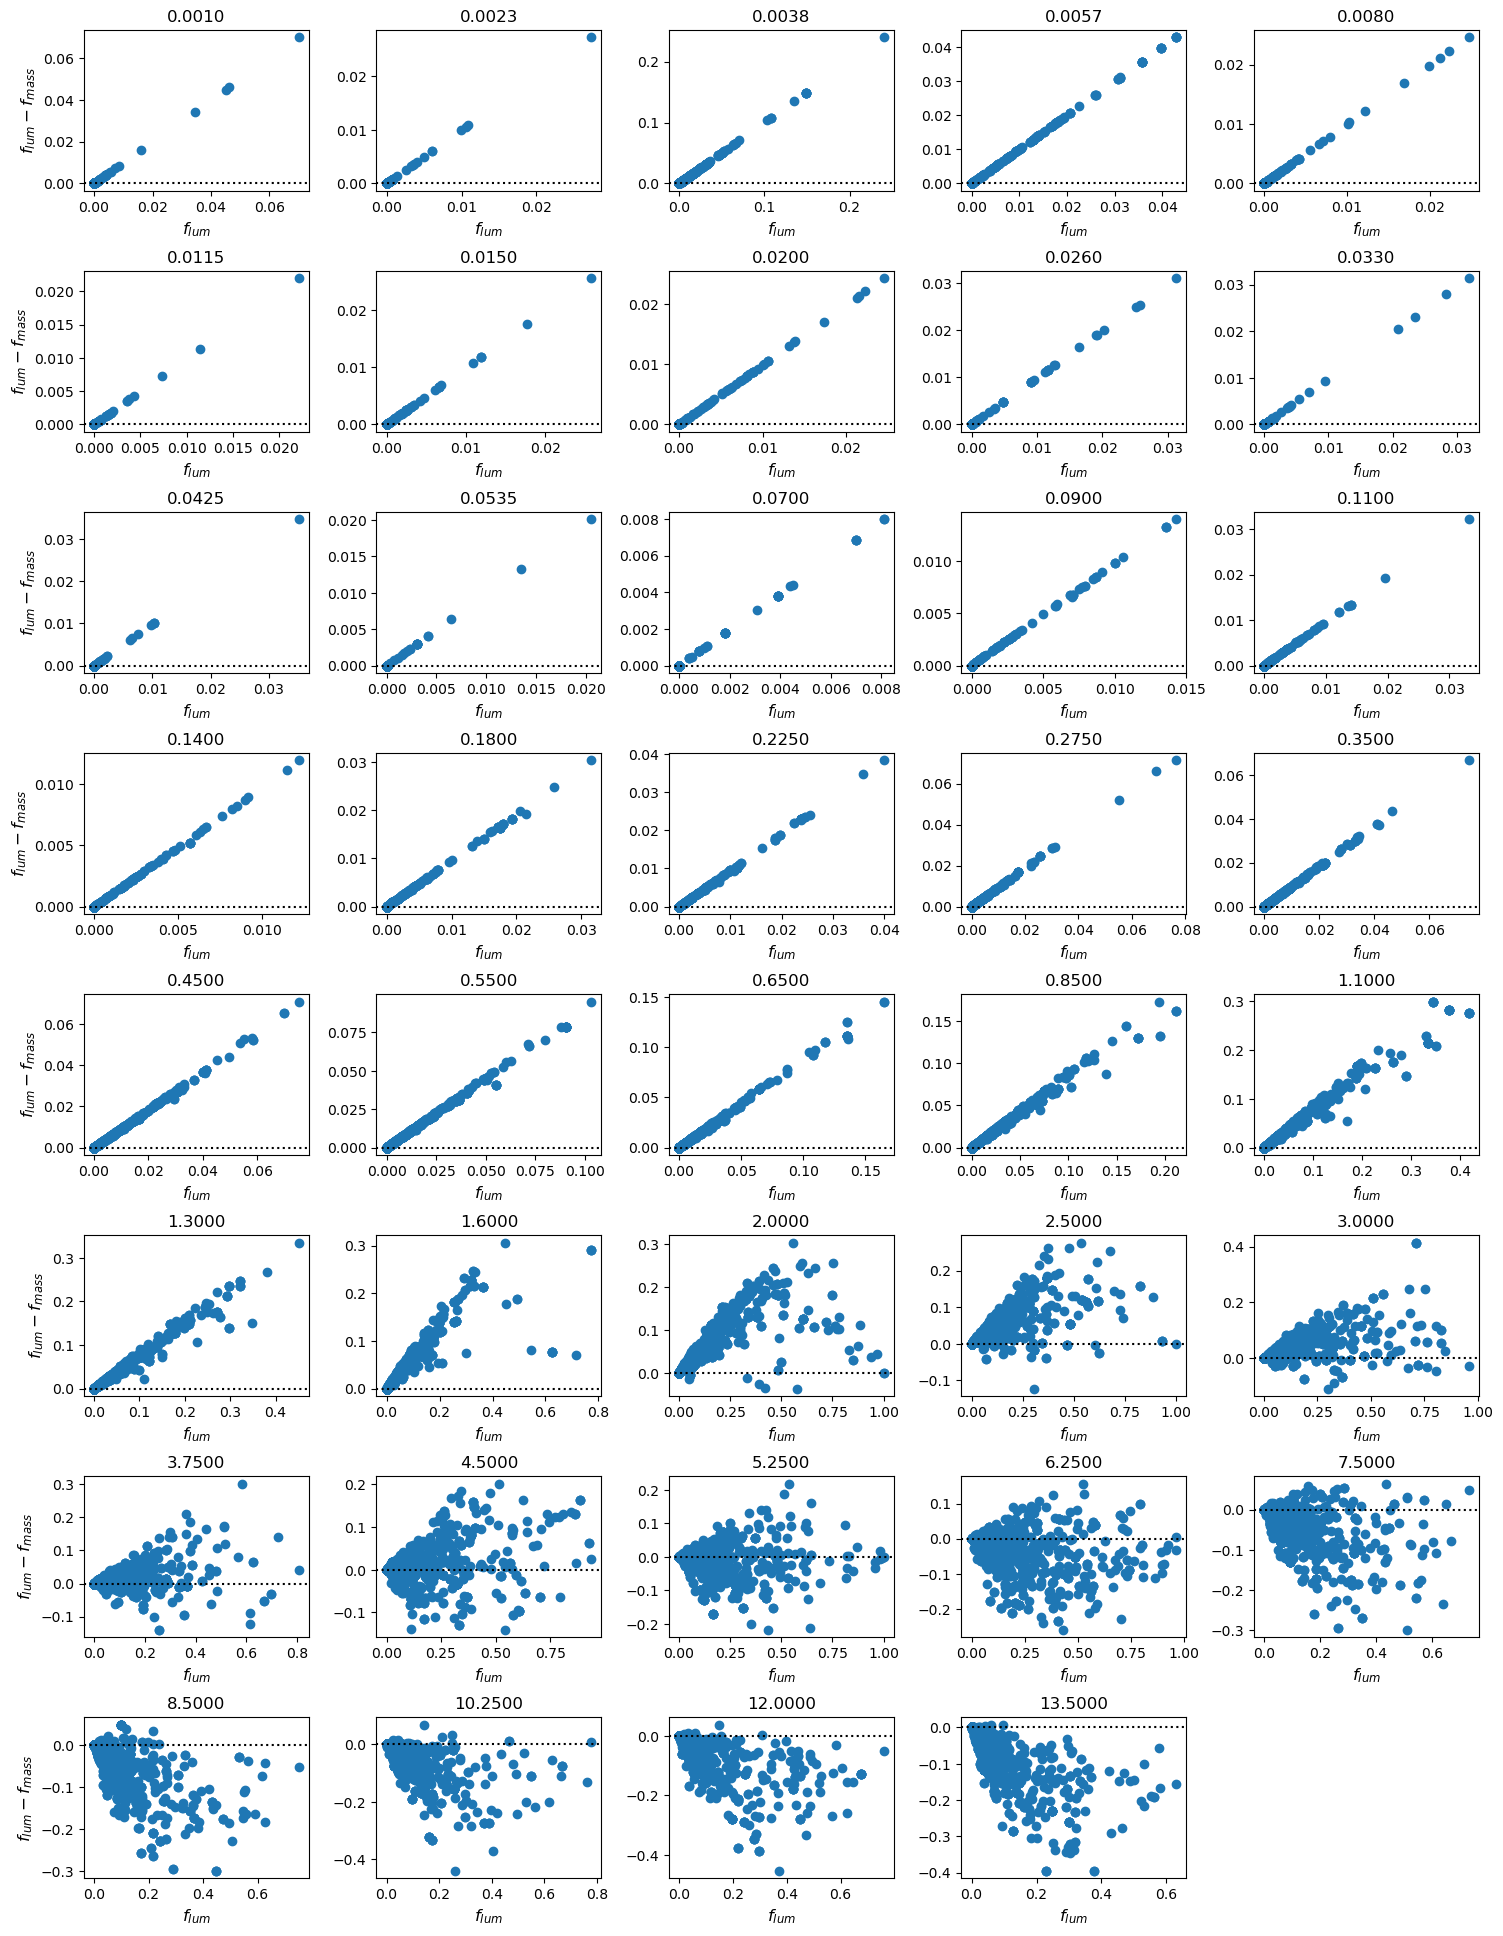

In [19]:
fig = plt.figure(figsize=(18,24))
for i, age in enumerate(sort_ages):
    ax = fig.add_subplot(8, 5, i+1)
    ax.scatter(sfh_new['lumfrac_age_'+age], sfh_new['lumfrac_age_'+age]-sfh_new['massfrac_age_'+age])
    ax.axhline(ls=':',color='k')
    ax.set_title(age)
    ax.set_xlabel(r'$f_{lum}$', fontsize='large')
    if i % 5 == 0:
        ax.set_ylabel(r'$f_{lum} - f_{mass}$', fontsize='large')
plt.subplots_adjust(hspace=0.5,wspace=0.3)

## Check the met aggregation

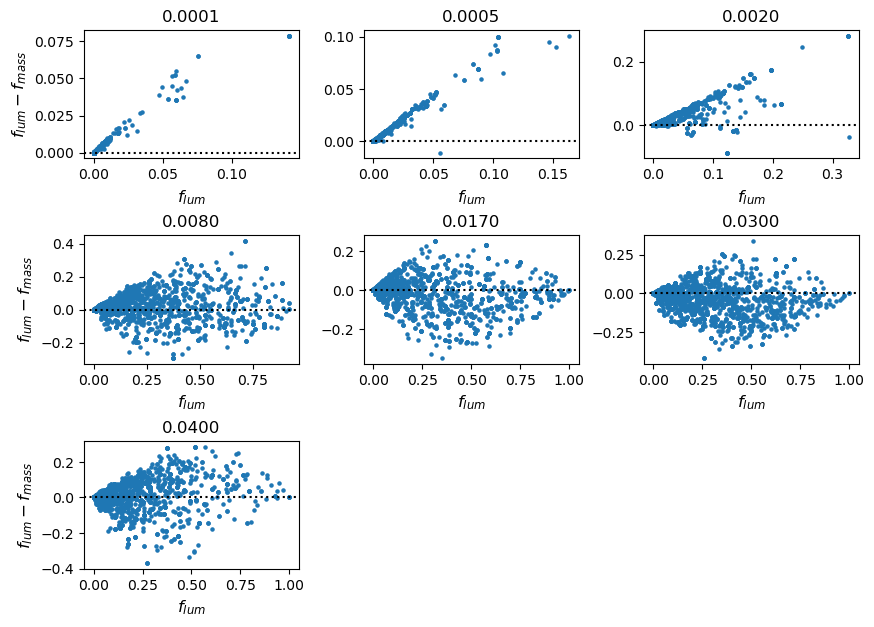

In [20]:
fig = plt.figure(figsize=(10,7))
for i, met in enumerate(sort_mets):
    ax = fig.add_subplot(3, 3, i+1)
    ax.scatter(sfh_new['lumfrac_met_'+met], sfh_new['lumfrac_met_'+met]-sfh_new['massfrac_met_'+met], s=5)
    ax.axhline(ls=':',color='k')
    ax.set_title(met)
    ax.set_xlabel(r'$f_{lum}$', fontsize='large')
    if i % 3 == 0:
        ax.set_ylabel(r'$f_{lum} - f_{mass}$', fontsize='large')
plt.subplots_adjust(hspace=0.6,wspace=0.3)